# ِِDownload dataset

In [ ]:
# install requirements
! pip3 install tensorflow sklearn opencv-contrib-python flask flask-ngrok numpy scipy bayesian-optimization
# download dataset
! git clone https://github.com/UCSD-AI4H/COVID-CT
! cp COVID-CT/Images-processed/{CT_COVID.zip,CT_NonCOVID.zip} .
! rm -rf COVID-CT
! unzip CT_COVID.zip
! unzip CT_NonCOVID.zip

# Preprocessing

In [ ]:
# Import dependencies.
import os
import numpy as np
import cv2
from scipy.io import savemat

# Create labels.
C = np.ones((349,))
N = np.zeros((397,))
labels = np.concatenate((C, N), axis=0)

# Load the datased and resize to imagenet size.
covid = os.listdir('CT_COVID')
n_covid = os.listdir('CT_NonCOVID')
data=[]


for img_path in covid:
  img = cv2.imread('CT_COVID/'+img_path, cv2.IMREAD_COLOR)
  data.append(cv2.resize(img, (224, 224)))
  

for img_path in n_covid:
  img = cv2.imread('CT_NonCOVID/'+img_path, cv2.IMREAD_COLOR)
  data.append(cv2.resize(img, (224, 224)))
  
# Normalization.
data = np.array(data)/255.
print(data.shape)
print(labels.shape)


(746, 224, 224, 3)
(746,)


# Visualization

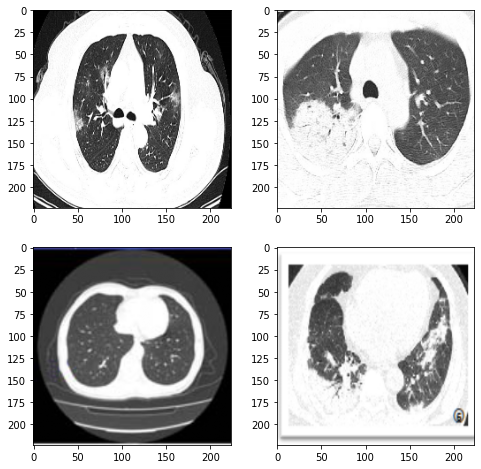

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].imshow(np.squeeze(data[40]), cmap='gray')
axs[0, 1].imshow(np.squeeze(data[50]), cmap='gray')
axs[1, 0].imshow(np.squeeze(data[30]), cmap='gray')
axs[1, 1].imshow(np.squeeze(data[150]), cmap='gray')


# Extract Features

In [ ]:
# This code performes a dimension reduction on the dataset,
# Using a DenseNet121 pretrained model.

import tensorflow as tf
import numpy as np


# Create the model.
inputs = tf.keras.Input(shape=(224, 224, 3))
# Here different models were tested, 
# TODO : add all the models in parallel with the best model.
model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet',
                                          input_shape=(224,224,3))
# Possibly try other models here.
model_outputs = model(inputs)
outputs = tf.keras.layers.GlobalAveragePooling2D(name='ga')(model_outputs)
feature_extractor = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Get features in a memory friendly way.
X = []
samples = data.shape[0]
for i in range(samples):
  X.append(feature_extractor(np.array([data[i]])))
X = np.array(X)
# Replace old images with features.
X = X.reshape(746, 1024)
Y = labels


# **Model(SVM) and optimization**

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
from bayes_opt import BayesianOptimization
from warnings import simplefilter
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter



def svm_evaluate(                
                NU,
                GAMMA,      
                MAX_ITER,):
    simplefilter(action='ignore')
    svm = NuSVC(nu=0.4, kernel='rbf', gamma=GAMMA, shrinking=True, tol=0.00001,
              max_iter=MAX_ITER, random_state=1, class_weight='balanced', probability=True)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)
    scores = cross_val_score(svm, X, Y, cv=cv)
    print(np.mean(scores))

    return np.mean(scores)
   
def bayesOpt(X, Y):
    pbound = {  'NU':  (0.4, 0.41),
                'MAX_ITER': (140.0, 190),
                 'GAMMA': (0.001, 0.01)
                                          }

    optimizer = BayesianOptimization(f = svm_evaluate, pbounds = pbound)


    optimizer.maximize(
    init_points=20,
    n_iter=1,)

    return   optimizer.max
    

params = bayesOpt(X, Y)
print(params)


|   iter    |  target   |   GAMMA   | MAX_ITER  |    NU     |
-------------------------------------------------------------
0.8646126126126126
|  1        |  0.8646   |  0.002763 |  182.5    |  0.4095   |
0.8846846846846848
|  2        |  0.8847   |  0.009789 |  164.4    |  0.4053   |
0.8686486486486485
|  3        |  0.8686   |  0.002611 |  188.4    |  0.4033   |
0.8673153153153154
|  4        |  0.8673   |  0.002456 |  146.6    |  0.4016   |
0.8927027027027027
|  5        |  0.8927   |  0.009379 |  185.4    |  0.4088   |
0.8766126126126126
|  6        |  0.8766   |  0.003289 |  152.2    |  0.4091   |
0.8458918918918918
|  7        |  0.8459   |  0.001101 |  172.9    |  0.4077   |
0.8766126126126126
|  8        |  0.8766   |  0.006118 |  146.8    |  0.4086   |
0.8686486486486485
|  9        |  0.8686   |  0.001709 |  171.1    |  0.4005   |
0.8886486486486488
|  10       |  0.8886   |  0.009431 |  149.2    |  0.4063   |
0.8860180180180179
|  11       |  0.886    |  0.007024 |  173.8   

# Results

In [ ]:
# Import Dependencies.
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter
from scipy.io import loadmat

# Calculate time.
s_time = time.time()
# Load the extracted features.

# Create the Classifier.
clf = NuSVC(nu=params['params']['NU'], gamma = params['params']['GAMMA'], kernel='rbf' , shrinking=True, tol=0.00001,
          max_iter=params['params']['MAX_ITER'], random_state=1, class_weight='balanced', probability=True)
simplefilter(action='ignore')

# Perform Cross Validation to Measure the Performance.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)

# TODO: Probably not the most optimal way to do this.
accuracy = cross_val_score(clf, X, Y, cv=cv)
scores = cross_val_score(clf, X, Y, cv=cv, scoring='roc_auc')
recall = cross_val_score(clf, X, Y, cv=cv, scoring='recall')
precision = cross_val_score(clf, X, Y, cv=cv, scoring='precision')
f1 = (2 * recall * precision) / (precision + recall)

print(f'time: {time.time() -  s_time}')
print(f'Accuracy: {np.mean(accuracy)} + {np.std(accuracy)}')
print(f'Area Under Curve: {np.mean(scores)} + {np.std(scores)}')
print(f'Recall: {np.mean(recall)} + {np.std(recall)}')
print(f'Presicion: {np.mean(precision)} + {np.std(precision)}')
print(f'f1 score: {np.mean(f1)} + {np.std(f1)}')


time: 30.747009754180908
Accuracy: 0.8860720720720721 + 0.04489221280166182
Area Under Curve: 0.9454335811247576 + 0.02357383709520469
Recall: 0.8826890756302521 + 0.05318896261391676
Presicion: 0.8802314023695603 + 0.06846940666654687
f1 score: 0.8794606662906286 + 0.045410330551599924


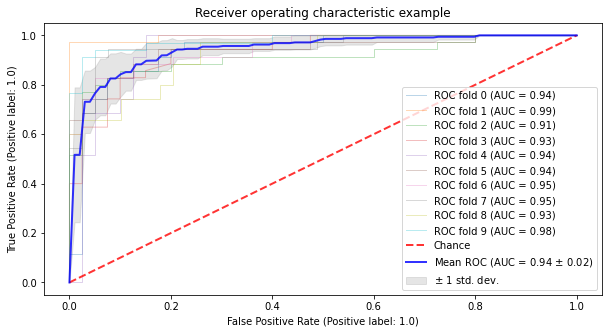

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (10, 5))
for i, (train, test) in enumerate(cv.split(X, Y)):
    clf.fit(X[train], Y[train])
    viz = plot_roc_curve(clf, X[test], Y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

# **Model(KNN)**

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
from bayes_opt import BayesianOptimization
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter
from scipy.io import loadmat


def knn_evaluate(X, Y):
    simplefilter(action='ignore')
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)
    neigh = KNeighborsClassifier(n_neighbors=3)
    scores = cross_val_score(neigh, X, Y, cv=cv)

    return np.mean(scores)
   

scores = knn_evaluate(X, Y)
print(scores)


0.8459279279279279


# Results

In [ ]:
# Import Dependencies.
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter
from scipy.io import loadmat

# Calculate time.
s_time = time.time()

# Create the Classifier.
clf = KNeighborsClassifier(n_neighbors=3)

# Perform Cross Validation to Measure the Performance.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)

# TODO: Probably not the most optimal way to do this.
accuracy = cross_val_score(clf, X, Y, cv=cv)
scores = cross_val_score(clf, X, Y, cv=cv, scoring='roc_auc')
recall = cross_val_score(clf, X, Y, cv=cv, scoring='recall')
precision = cross_val_score(clf, X, Y, cv=cv, scoring='precision')
f1 = (2 * recall * precision) / (precision + recall)

print(f'time: {time.time() -  s_time}')
print(f'Accuracy: {np.mean(accuracy)} + {np.std(accuracy)}')
print(f'Area Under Curve: {np.mean(scores)} + {np.std(scores)}')
print(f'Recall: {np.mean(recall)} + {np.std(recall)}')
print(f'Presicion: {np.mean(precision)} + {np.std(precision)}')
print(f'f1 score: {np.mean(f1)} + {np.std(f1)}')


time: 0.777522087097168
Accuracy: 0.8459279279279279 + 0.04165822266520419
Area Under Curve: 0.894600813402284 + 0.033674090397459736
Recall: 0.8454621848739496 + 0.063877099795288
Presicion: 0.8305478829078149 + 0.04892075197844671
f1 score: 0.8364670777028484 + 0.04544339479389993


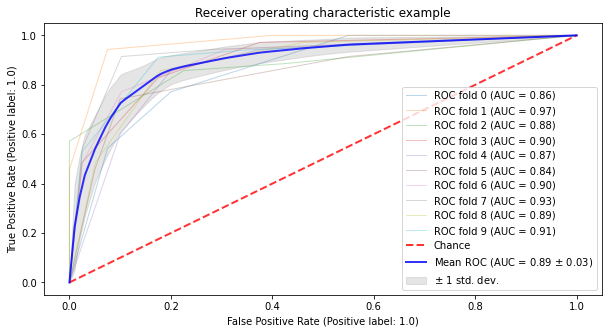

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (10, 5))
for i, (train, test) in enumerate(cv.split(X, Y)):
    clf.fit(X[train], Y[train])
    viz = plot_roc_curve(clf, X[test], Y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()